In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import random
from sklearn.metrics import classification_report







In [ ]:
train_dir = "data/chest_xray/train"
val_dir   = "data/chest_xray/val"
test_dir  = "data/chest_xray/test"
classes = ["NORMAL", "PNEUMONIA"]


In [ ]:
original_counts = {}
for cls in classes:
    original_counts[cls] = len(os.listdir(os.path.join(train_dir, cls)))

print("Original Train Set Counts:")
for cls, count in original_counts.items():
    print(f"{cls}: {count} images")

Original Train Set Counts:
NORMAL: 1341 images
PNEUMONIA: 3875 images


C:\Users\nahal\AppData\Local\Temp\ipykernel_30708\674931555.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette="Blues_d")


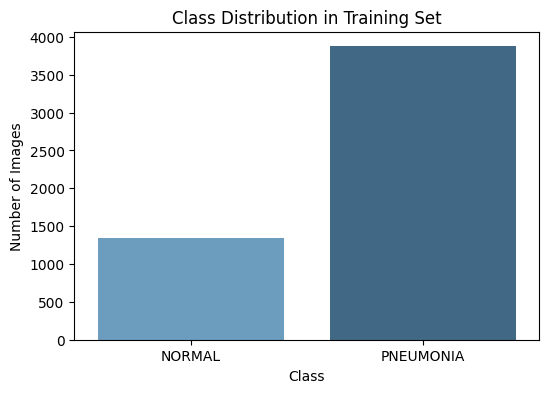

In [ ]:
labels = list(original_counts.keys())
values = list(original_counts.values())

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=values, palette="Blues_d")
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
TARGET_SIZE = (150, 150) 
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    subset='training'
)

Found 4173 images belonging to 2 classes.


In [ ]:

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=TARGET_SIZE,
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    subset='validation'
)

Found 1043 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=TARGET_SIZE,
    batch_size=32,
    color_mode='rgb',
    class_mode='binary',
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [ ]:

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights)


Class Weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


In [ ]:

unique, counts = np.unique(train_generator.classes, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("\n=== Original Class Counts ===")
for cls, count in class_distribution.items():
    print(f"{list(train_generator.class_indices.keys())[cls]}: {count}")


=== Original Class Counts ===
NORMAL: 1073
PNEUMONIA: 3100


In [ ]:

# Weightedbalanced counts
balanced_counts = {cls: int(count * class_weights[i]) for i, (cls, count) in enumerate(class_distribution.items())}

print("\n=== Balanced (Weighted) Class Counts (approximate) ===")
for cls, count in balanced_counts.items():
    print(f"{list(train_generator.class_indices.keys())[cls]}: {count}")


=== Balanced (Weighted) Class Counts (approximate) ===
NORMAL: 2086
PNEUMONIA: 2086


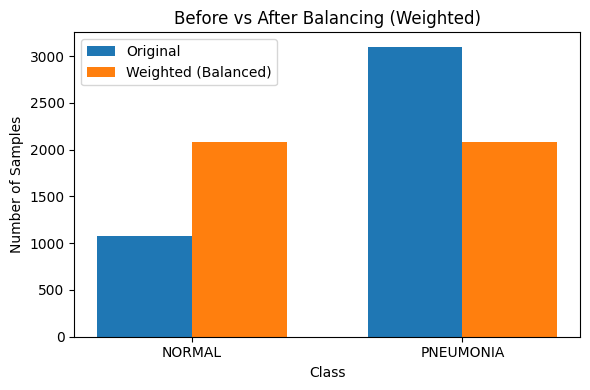

In [ ]:
labels = [list(train_generator.class_indices.keys())[cls] for cls in class_distribution.keys()]

plt.figure(figsize=(6,4))
bar_width = 0.35
x = np.arange(len(labels))

plt.bar(x - bar_width/2, class_distribution.values(), bar_width, label='Original')
plt.bar(x + bar_width/2, balanced_counts.values(), bar_width, label='Weighted (Balanced)')
plt.xticks(x, labels)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Before vs After Balancing (Weighted)")
plt.legend()
plt.tight_layout()
plt.show()

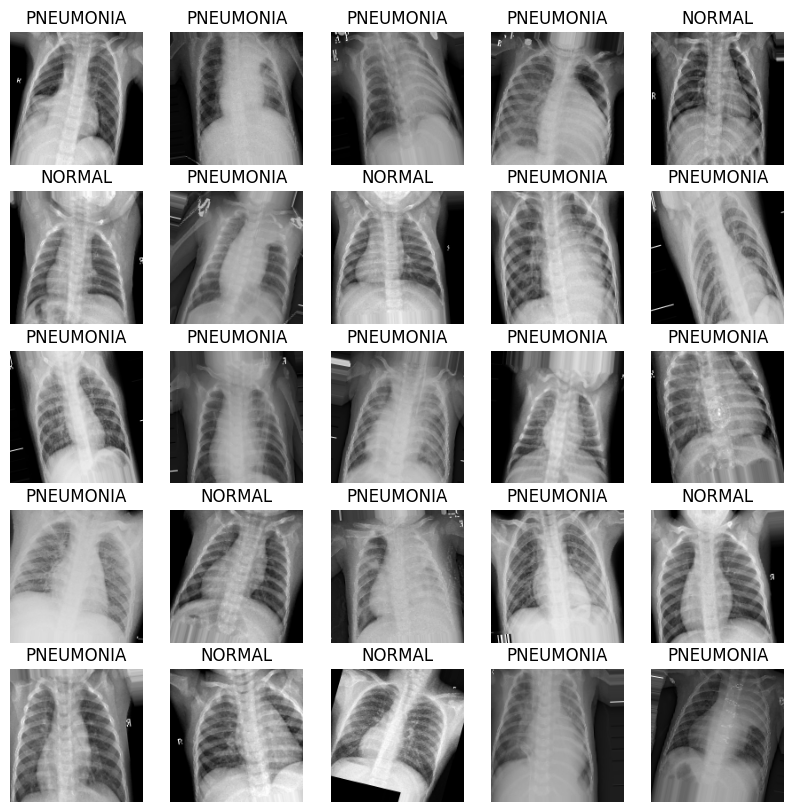

In [ ]:
x_batch, y_batch = next(train_generator)  
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_batch[i])
    plt.title("NORMAL" if y_batch[i]==0 else "PNEUMONIA")
    plt.axis('off')
plt.show()

In [ ]:
model = models.Sequential([
   
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2,2),

    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),


    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),             # Prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Binary output
])

d:\MyProjects\diseasedetection-chestxray\xray\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights
)

d:\MyProjects\diseasedetection-chestxray\xray\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 130s 980ms/step - accuracy: 0.5883 - loss: 0.6449 - val_accuracy: 0.8092 - val_loss: 0.4125
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 122s 928ms/step - accuracy: 0.8358 - loss: 0.3679 - val_accuracy: 0.8188 - val_loss: 0.3991
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 917ms/step - accuracy: 0.8737 - loss: 0.2999 - val_accuracy: 0.8102 - val_loss: 0.4084
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8955 - loss: 0.2569 - val_accuracy: 0.8639 - val_loss: 0.3396
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.9058 - loss: 0.2294 - val_accuracy: 0.8993 - val_loss: 0.2379
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 969ms/step - accuracy: 0.9168 - loss: 0.2030 - val_accuracy: 0.9003 - val_loss: 0.2492
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 126s 961ms/step - accuracy: 0.9173 - loss: 0.2093 - val_accuracy: 0.9175 - val_loss: 0.2026
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 124s 947ms/step - accuracy: 0.9298 - loss:

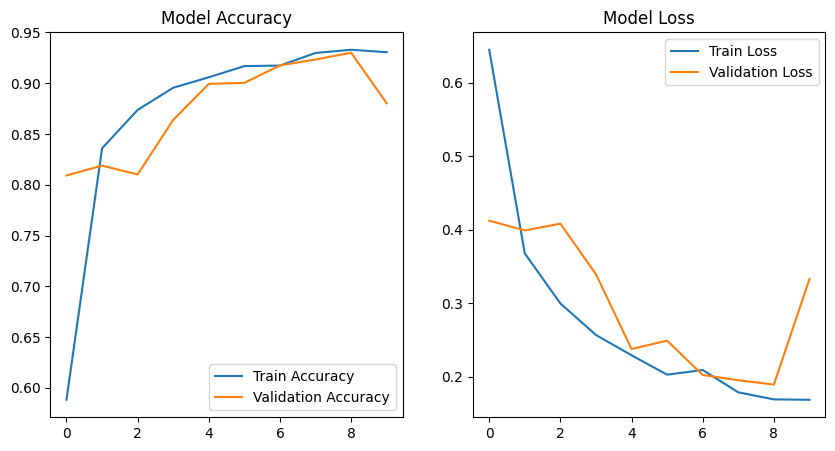

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.8750 - loss: 0.2954

✅ Test Accuracy: 87.50%


In [ ]:
y_pred = (model.predict(test_generator) > 0.5).astype("int32")
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step


In [ ]:
class_names = list(test_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.82      0.86      0.84       234
   PNEUMONIA       0.91      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



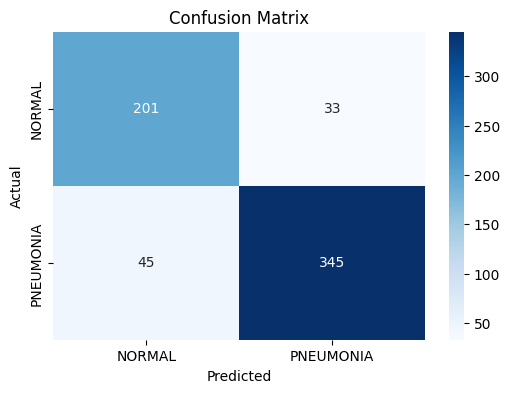

In [ ]:

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()